# Solar ANN 

### Load and preprocess data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('/Users/ben/Desktop/Senior-project/Final_Merged_Energy_and_Weather_Data.csv')
data = data.fillna(0)

features = data[['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windgust', 
            'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation']]
target = data['solarenergy']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (8076, 12)
Target shape:  (8076,)


### Build the ANN

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50
162/162 [==============================] - 3s 5ms/step - loss: 0.0691 - val_loss: 0.0031
Epoch 2/50
162/162 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 3/50
162/162 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.7311e-04
Epoch 4/50
162/162 [==============================] - 0s 2ms/step - loss: 8.2811e-04 - val_loss: 7.4801e-04
Epoch 5/50
162/162 [==============================] - 0s 2ms/step - loss: 5.4913e-04 - val_loss: 5.3302e-04
Epoch 6/50
162/162 [==============================] - 0s 2ms/step - loss: 5.5991e-04 - val_loss: 5.2637e-04
Epoch 7/50
162/162 [==============================] - 0s 2ms/step - loss: 5.6565e-04 - val_loss: 0.0011
Epoch 8/50
162/162 [==============================] - 0s 2ms/step - loss: 8.0572e-04 - val_loss: 3.9942e-04
Epoch 9/50
162/162 [==============================] - 0s 2ms/step - loss: 3.5437e-04 - val_loss: 2.6558e-04
Epoch 10/50
162/162 [==============================]

### Analysis

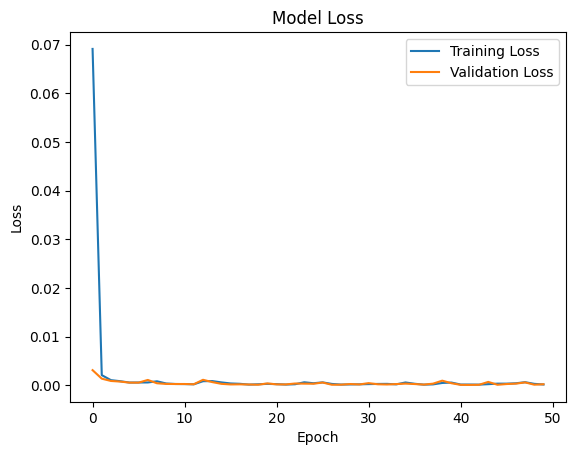

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [10]:
predictions = model.predict(X_test)

print(f'Predicted Solar Energy Ouput: {predictions[:5]}')
print(f'Actual Solar Energy Output: {y_test[:5].values}')

51/51 [==============================] - 0s 2ms/step
Predicted Solar Energy Ouput: [[2.9152259e-05]
 [2.5970690e+00]
 [2.0515741e-01]
 [4.2778961e-03]
 [8.7871701e-03]]
Actual Solar Energy Output: [0.  2.6 0.2 0.  0. ]


### Save model

In [12]:
model.save('SolarModel.h5')